# Evaluation for IR

Here we are only going to look at offline evaluation metrics. We won't cover online evaluation techniques like click-through rate or running A/B tests where a subset of users are presented results from a newer test system.

## Offline evaluation

The idea behind these evaluations is to quantitatively compare multiple IR models. Typically we have a labelled dataset where we have queries mapped to relvevant documents. The documents could either be graded or non-graded(binary). For example, a graded relevance score could be on a scale of 0-5 with 5 being the most relevant.

Labelled data typicalls comes form manual annotations or click data.

It's also not necessary to have just 1 document tagged as relevant for each query. TREC collections have 100s of documents tagged as relevant per quuery. On the other hand MSMARCO has ~1 document tagged as relevant per query. This tends to be quite noisy but easy to scale hence more variability in the queries.

## Binary labels

### Precision@k

Precision@k corresponds to the number of relevant documents among top k retrieved documents.

$$ Precision@k = \frac{TP@k}{TP@k + FP@k} $$

| ![](assets/precision@k.png) | 
|:--:| 
| Fig. 1. Illustration of Precision@k for evaluating IR models. |

Precision fails to take into account the ordering of the relevant documents. For example consider the models A and B (Fig 2) where model A outputs `[1,1,1,0,0](first 3 relevant)` and model B outputs `[0,0,1,1,1](indices 3-5 relevant)`; both the models get the same score `Precision@5=3/5`.

### MAP@k: Mean Average Precision

*Average Precision(AP)* evaluates whether all the relevant items selected by the model are ranked higher or not.
Every time we find a relevant document, we look at the full picture of what came before.

MAP squeezes complex evaluation into a single number. It's essentially the mean of AP over all the queries.

$$ AP@k(q) = \frac{\sum_{i=1}^k P(q)@i * rel(q)_i}{|rel(q)|} $$

$$ MAP@k(Q) = \frac{1}{|Q|} * \sum_{q\in Q} AP@k(q) $$

|Q| - Number of queries<br>
𝑃(𝑞)@𝑖 - Precision of query q after first i documents<br>
𝑟𝑒𝑙(𝑞)𝑖 - Binary relevance of doc at position i<br>
|𝑟𝑒𝑙(𝑞)| - Number of relevant documents

| ![](assets/ap.png) | 
|:--:| 
| Fig. 2. Illustration of AveragePrecision@k for evaluating IR models. |

### MRR: Mean Reciprocal Rank

MRR puts focus on the first relevant document. It's applicable when the system needs to return only the top matching document or the user only cares about the top result.

$$ MRR(Q) = \frac{1}{|Q|} * \sum_{q\in Q} \frac{1}{FirstRank(q)} $$

|Q| - Number of queries<br>
*FirstRank(q)* - Returns the rank of first relevant dcuments for 1 query

MRR(for 1 query) for different positions can be seen below. Notice the sharp fall in the values beyond the top few places.

In [1]:
import math

import matplotlib.pyplot as plt
%matplotlib inline

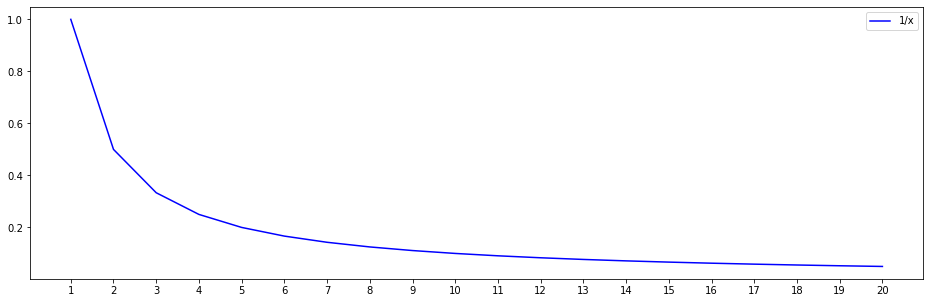

In [2]:
N = 20
plt.figure(figsize=(16, 5));
plt.plot(range(1, N+1), [1/n for n in range(1, N+1)], c="b", label="1/x");
plt.legend();
plt.xticks(range(1, N+1, 1));

** Note that the metrics related to **Recall** are not used in general because it is easy to achieve a recall of 100% by returning all documents for a query.

## Graded labels

### nDCG@k: Normalized Discounted Cumulative Gain

To understand nDCG, first let's look at CG i.e. Cumulative Gain. We simply add up the relevace scores for top k documents returned for a query.

$$ CG@k(q) = \sum_{i=1}^k rel(q)_i $$

| ![](assets/cg@k.png) | 
|:--:| 
| Fig. 3. Illustration of CumulativeGain@k for evaluating IR models. |

Note that CG does not take into account the position of the document. For example consider the models A and B where model A outputs `[5,2,4,0,1]` and model B outputs `[2,0,5,1,4]`; both the models get the same score `CG@5=12`.

DCG i.e. Discounted Cumulative Gain improves on CG by adding a discounting factor for each position.

$$ DCG@k(q) = \sum_{i=1}^k \frac{rel(q)_i}{log_2(i+1)} $$

𝑟𝑒𝑙(𝑞)𝑖 - Graded relevance of doc at position i

In [3]:
import math
from typing import List

import pandas as pd


def _get_dcg_at_k(scores: List[int]) -> pd.DataFrame:
    cols = ["position(i)", "relevance(i)", "log2(i+1)", "relevance(i) / log2(i+1)"]

    data = []
    for i, score in enumerate(scores):
        position = i + 1
        data.append((position, score, math.log2(position+1), score / math.log2(position+1)))

    return pd.DataFrame(data, columns=cols)


def get_dcg_at_k(scores: List[int]) -> None:
    df = _get_dcg_at_k(scores)
    
    dcg_so_far = ""
    for i, dcg in enumerate(df["relevance(i) / log2(i+1)"]):
        if not dcg_so_far:
            dcg_so_far = f"{dcg:2.2f}"
        else:
            dcg_so_far = f"{dcg_so_far} + {dcg:2.2f}"
        print(f"DCG@{i+1} = {dcg_so_far:<32} = {eval(dcg_so_far):2.2f}")
    
    return df

Now we can compare the results from the two models A and B we mentioned earlier.

In [4]:
get_dcg_at_k([5, 2, 4, 0, 1])  # model A

DCG@1 = 5.00                             = 5.00
DCG@2 = 5.00 + 1.26                      = 6.26
DCG@3 = 5.00 + 1.26 + 2.00               = 8.26
DCG@4 = 5.00 + 1.26 + 2.00 + 0.00        = 8.26
DCG@5 = 5.00 + 1.26 + 2.00 + 0.00 + 0.39 = 8.65


,position(i),relevance(i),log2(i+1),relevance(i) / log2(i+1)
0,1,5,1.000000,5.000000
1,2,2,1.584963,1.261860
2,3,4,2.000000,2.000000
3,4,0,2.321928,0.000000
4,5,1,2.584963,0.386853


In [5]:
get_dcg_at_k([2, 0, 5, 1, 4])  # model B

DCG@1 = 2.00                             = 2.00
DCG@2 = 2.00 + 0.00                      = 2.00
DCG@3 = 2.00 + 0.00 + 2.50               = 4.50
DCG@4 = 2.00 + 0.00 + 2.50 + 0.43        = 4.93
DCG@5 = 2.00 + 0.00 + 2.50 + 0.43 + 1.55 = 6.48


,position(i),relevance(i),log2(i+1),relevance(i) / log2(i+1)
0,1,2,1.000000,2.000000
1,2,0,1.584963,0.000000
2,3,5,2.000000,2.500000
3,4,1,2.321928,0.430677
4,5,4,2.584963,1.547411


DCG solves the problem with CG but it also has a drawback, it can't be used to compare queries/models that return different number of results.
For example consider query A and B where query A returns `[5,2,4]` query B returns `[5,2,4,0,1]`;

In [6]:
get_dcg_at_k([5, 2, 4])  # query A

DCG@1 = 5.00                             = 5.00
DCG@2 = 5.00 + 1.26                      = 6.26
DCG@3 = 5.00 + 1.26 + 2.00               = 8.26


,position(i),relevance(i),log2(i+1),relevance(i) / log2(i+1)
0,1,5,1.000000,5.00000
1,2,2,1.584963,1.26186
2,3,4,2.000000,2.00000


In [7]:
get_dcg_at_k([5, 2, 4, 0, 1])  # query B

DCG@1 = 5.00                             = 5.00
DCG@2 = 5.00 + 1.26                      = 6.26
DCG@3 = 5.00 + 1.26 + 2.00               = 8.26
DCG@4 = 5.00 + 1.26 + 2.00 + 0.00        = 8.26
DCG@5 = 5.00 + 1.26 + 2.00 + 0.00 + 0.39 = 8.65


,position(i),relevance(i),log2(i+1),relevance(i) / log2(i+1)
0,1,5,1.000000,5.000000
1,2,2,1.584963,1.261860
2,3,4,2.000000,2.000000
3,4,0,2.321928,0.000000
4,5,1,2.584963,0.386853


Query B got higher DCG because it returned 5 documents whereas query A only returned 3. We can't say that query B was better than query A.
nDCG fixes this issue by adding a normalization factor on top of DCG.

$$ nDCG@k(Q) = \frac{1}{|Q|} * \sum_{q\in Q} \frac{DCG@k(q)}{DCG@k(sorted(rel(q)))} $$

|Q| - Number of queries

The normalization factor 𝐷𝐶𝐺@𝑘(𝑠𝑜𝑟𝑡𝑒𝑑(𝑟𝑒𝑙(𝑞))) is the Ideal DCG@k. This is calculated by sorting the graded relevance scores returned for a query and then calculating the DCG@k. nDCG@k always lie between 0 and 1.

Now we can compare queries/models with different number of results.

In [8]:
get_dcg_at_k(sorted([5, 2, 4], reverse=True))  # Ideal DCG@k for query A

DCG@1 = 5.00                             = 5.00
DCG@2 = 5.00 + 2.52                      = 7.52
DCG@3 = 5.00 + 2.52 + 1.00               = 8.52


,position(i),relevance(i),log2(i+1),relevance(i) / log2(i+1)
0,1,5,1.000000,5.000000
1,2,4,1.584963,2.523719
2,3,2,2.000000,1.000000


nDCG@3 for query A = 8.26 / 8.52 = 0.9694

In [9]:
get_dcg_at_k(sorted([5, 2, 4, 0, 1], reverse=True))  # Ideal DCG@k for query B

DCG@1 = 5.00                             = 5.00
DCG@2 = 5.00 + 2.52                      = 7.52
DCG@3 = 5.00 + 2.52 + 1.00               = 8.52
DCG@4 = 5.00 + 2.52 + 1.00 + 0.43        = 8.95
DCG@5 = 5.00 + 2.52 + 1.00 + 0.43 + 0.00 = 8.95


,position(i),relevance(i),log2(i+1),relevance(i) / log2(i+1)
0,1,5,1.000000,5.000000
1,2,4,1.584963,2.523719
2,3,2,2.000000,1.000000
3,4,1,2.321928,0.430677
4,5,0,2.584963,0.000000


nDCG@5 for query B = 8.65 / 8.95 = 0.9664

---

## References

[1] Sebastian Hofstätter. "[Advanced Information Retrieval 2021 @ TU Wien](https://www.youtube.com/playlist?list=PLSg1mducmHTPZPDoal4m59pPxxsceXF-y)"

[2] Amit Chaudhary. "https://amitness.com/2020/08/information-retrieval-evaluation/"